## Comparing XGBoost and neural networks on a tabular heart disease dataset

This notebook aims to compare the performance of two widely-used, but very different, models on a Kaggle dataset (https://www.kaggle.com/fedesoriano/heart-failure-prediction/tasks?taskId=6055) which aims to predict heart disease onset using a range of patient information. The notebook will use scikit-learn's implementation of XGBoost and CatBoost and tensorflow's neural networks. Hyperparameter optimization will be run for all models and the performance will be compared. Various ensembles of the models will also be tested.

In [1]:
# install some packages

# ! pip install xgboost
# ! pip install catboost

In [2]:
# from looking at Kaggle, this dataset is quite clean, no missing values etc. so can skip straight to the model building phase
# (but some pre-processing is still needed)

# import dataset
import pandas as pd
dataset = pd.read_csv('heart.csv')

# encode categorical data labels as numerical
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
dataset["RestingECG"] = le.fit_transform(dataset["RestingECG"])
dataset["ST_Slope"] = le.fit_transform(dataset["ST_Slope"])
dataset["ExerciseAngina"] = le.fit_transform(dataset["ExerciseAngina"])
dataset["ChestPainType"] = le.fit_transform(dataset["ChestPainType"])
dataset["Sex"] = le.fit_transform(dataset["Sex"])

# split into X and y
y = dataset["HeartDisease"]
X = dataset.drop(columns=["HeartDisease"])

# scale variables to lie in same range
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split into train/test set
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



In [3]:
# Do hyperparameter optimization by bayes search cross validation
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, precision_score, recall_score, accuracy_score

hp_opt = True

#     search_space = {"n_estimators": Integer(600, 900),
#             "max_depth": Integer(8, 15),
#             "learning_rate": Real(0.05, 0.3), 
#             "reg_alpha": Real(0, 1),
#             "reg_lambda": Real(0, 1),
#             "gamma": Real(0, 1),

if hp_opt:
    search_space = {"n_estimators": Integer(400, 1200),
            "max_depth": Integer(2, 15),
            "learning_rate": Real(0.05, 0.3), 
            "reg_alpha": Real(0, 2),
            "reg_lambda": Real(0, 2),
            "gamma": Real(0, 2),
    #         "min_child_weight": Real(0, 50),
    #         "use_label_encoder":Categorical([False]),
    #         'binary:logistic':Categorical(["logloss"]),
    #         'max_delta_step': Real(0, 20),
    #         'subsample': Real(0, 1.0, 'uniform')
        }

    XGB_bayes_search = BayesSearchCV(
        estimator = XGBClassifier(
            n_jobs = 1,
            objective = 'binary:logistic',
            iid="False"
        ),
        search_spaces = search_space,
        scoring = 'accuracy',
        cv = StratifiedKFold(n_splits=5),
        n_jobs = 3,
        n_iter = 64
        )

    def callback(res):
        global i
        print("Run ",i)
        i += 1

    i = 0
    XGB_bayes_search.fit(X_train, y_train, callback=callback)

    best_params = XGB_bayes_search.best_params_
    best_estimator = XGB_bayes_search.best_estimator_
    best_score = XGB_bayes_search.best_score_

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17


C:\Users\jonatan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Run  18
Run  19
Run  20
Run  21
Run  22
Run  23
Run  24
Run  25
Run  26
Run  27
Run  28
Run  29
Run  30
Run  31
Run  32
Run  33
Run  34
Run  35


C:\Users\jonatan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Run  36
Run  37
Run  38
Run  39
Run  40
Run  41
Run  42
Run  43
Run  44
Run  45
Run  46
Run  47
Run  48
Run  49
Run  50
Run  51


C:\Users\jonatan\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Run  52
Run  53
Run  54
Run  55
Run  56
Run  57
Run  58
Run  59
Run  60
Run  61
Run  62
Run  63
[09:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "iid" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:40:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jonatan\AppData\Roaming\Python\Python37\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [4]:
if hp_opt:
    print(best_params)
    print("Best CV score:")
    print(best_score)
    print("refit model test set score:")
    print(XGB_bayes_search.score(X_test, y_test))
    print("refit model test set score: (other method) - it should be the same, but sometimes isn't - why?")
    print(XGB_bayes_search.best_estimator_.score(X_test, y_test))

OrderedDict([('gamma', 1.9663341512620622), ('learning_rate', 0.0734395586996158), ('max_depth', 3), ('n_estimators', 484), ('reg_alpha', 0.3656307218165796), ('reg_lambda', 1.0384737915707287)])
Best CV score:
0.8678474114441417
refit model test set score:
0.9184782608695652
refit model test set score: (other method) - it should be the same, but sometimes isn't - why?
0.9184782608695652


AUC:  0.8682448589191775
Precision:  0.8333333333333334
Recall:  0.9803921568627451
Accuracy:  0.8804347826086957

Confusion matrix: 
     pred_neg  pred_pos
neg        62        20
pos         2       100


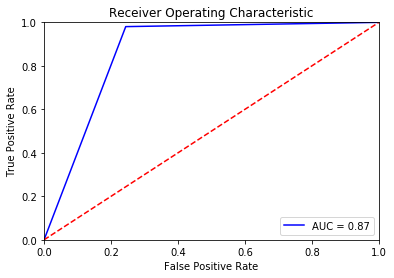

In [25]:
# Model Building

clf = best_estimator

# run the fitted model on the test set and obtain the probabilities that each data point lies in each class
y_prob = clf.predict_proba(X_test)

# set the probabilty threshold to determine precision/recall tradeoff
threshold = 0.35

# obtain 1/0 list based on if probabiltiy is above/below threshold
certainty = y_prob[:, 1] > threshold
y_pred = certainty.astype(int)  

# calculate metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)


print("AUC: ", roc_auc)
print("Precision: " , prec)
print("Recall: " , rec)
print("Accuracy: ", acc)

print("")
print("Confusion matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
# Now try a Neural Network
import tensorflow as tf
import keras_tuner as kt

hp_opt_nn = True

if hp_opt_nn:
    # split train set into cv train set and validation set
    X_train_cv, X_val, y_train_cv, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

    # model building function with custom hyperparameters
    def build_model(hp):
        inputs = tf.keras.Input(shape=(11,))
        x = inputs

        x = tf.keras.layers.Dense(hp.Int('layer_size_1', 3, 11, step=1), activation='relu')(x)
        x = tf.keras.layers.Dense(hp.Int('layer_size_2', 3, 11, step=1), activation='relu')(x)
        x = tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.0, 0.5, step=0.05, default=0.2))(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
        outputs = x

        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-3, 1e-1, sampling='log')),
            loss='binary_crossentropy', 
            metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
        return model

    tuner = kt.Hyperband(build_model, objective="val_accuracy", max_epochs=30, overwrite=True)

    # search for optimal hyperparameters
    tuner.search(X_train_cv, y_train_cv,
                 validation_data=(X_val, y_val),
                 epochs=30,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

    best_model = tuner.get_best_models(1)[0]

Trial 90 Complete [00h 00m 09s]
val_accuracy: 0.8639456033706665

Best val_accuracy So Far: 0.8775510191917419
Total elapsed time: 00h 07m 12s
INFO:tensorflow:Oracle triggered exit


In [26]:
# now run best model on test set (wasn't used during cross-validation)

# loss_nn, acc_nn, rec_nn, prec_nn, auc_nn = best_model.evaluate(X_test, y_test)

# predict class probabilities using NN model
y_prob_nn = best_model.predict(X_test)

# obtain 1/0 list based on if probabiltiy is above/below threshold
# set threshold so that both models have around 98% recall, and can be compared
threshold = 0.15
certainty = y_prob_nn > threshold
y_pred_nn = certainty.astype(int)  

# calculate metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred_nn)
roc_auc_nn = auc(fpr, tpr)
prec_nn = precision_score(y_test, y_pred_nn)
rec_nn = recall_score(y_test, y_pred_nn)
acc_nn = accuracy_score(y_test, y_pred_nn)

# print model summary
best_model.summary()

print("accuracy: ", acc_nn)
print("Recall: ", rec_nn)
print("Precision: ", prec_nn)
print("AUC: ", roc_auc_nn)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
accuracy:  0.8369565217391305
Recall:  0.9803921568627451
Precision:  0.78125
AUC:  0.8194643711142993


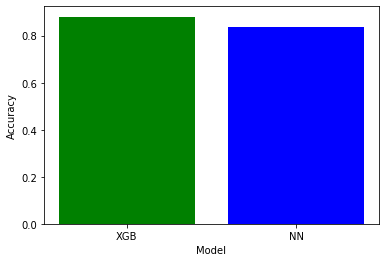

XGB Accuracy :  0.8804
NN Accuracy :  0.837


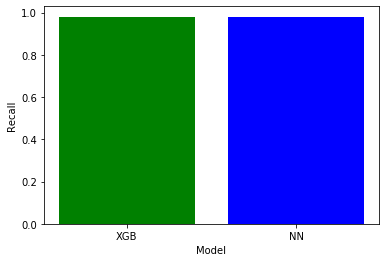

XGB Recall :  0.9804
NN Recall :  0.9804


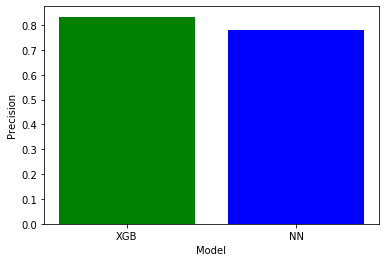

XGB Precision :  0.8333
NN Precision :  0.7812


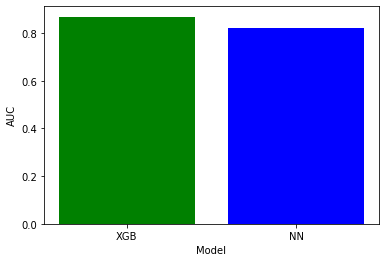

XGB AUC :  0.8682
NN AUC :  0.8195


In [27]:
# visualise metrics for XGBoost and NN

import matplotlib.pyplot as plt

def plot_metric(metrics, metric_name, model_names, colours):
    plt.bar(x=(model_names[0], model_names[1]), height=(metrics[0], metrics[1]), color=(colours[0], colours[1]))
    plt.ylabel(metric_name)
    plt.xlabel("Model")
    plt.show()    
    print(model_names[0], metric_name, ": ",  round(metrics[0], 4))
    print(model_names[1], metric_name, ": ",  round(metrics[1], 4))
    
plot_metric((acc, acc_nn), "Accuracy", ["XGB", "NN"], colours=["green", "blue"])
plot_metric((rec, rec_nn), "Recall", ["XGB", "NN"], colours=["green", "blue"])
plot_metric((prec, prec_nn), "Precision", ["XGB", "NN"], colours=["green", "blue"])
plot_metric((roc_auc, roc_auc_nn), "AUC", ["XGB", "NN"], colours=["green", "blue"])

Both the XGB and NN models have had their decision boundaries tuned to give a recall score of 98% (recall is very important in a heart disease dataset). Doing so, The XGB model slightly outperformed the NN in all used metrics; accuracy, precision and AUC. Running this notebook several times however, it was found that both models are quite unstable and lead to varying final test set metrics. Therefore, to give a better representation, the whole notebook should be run several times. From this, a mean and uncertainty in the metrics could be obtained.


accuracy:  0.8858695652173914
Recall:  0.9803921568627451
Precision:  0.8403361344537815
AUC:  0.8743424198947873


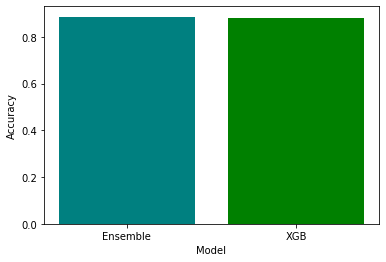

Ensemble Accuracy :  0.8859
XGB Accuracy :  0.8804


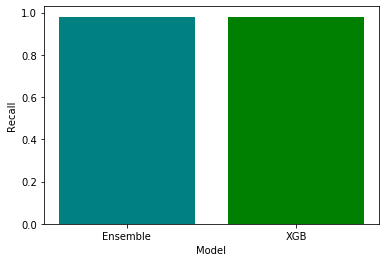

Ensemble Recall :  0.9804
XGB Recall :  0.9804


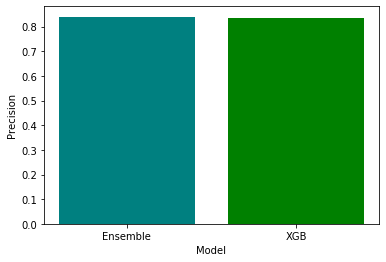

Ensemble Precision :  0.8403
XGB Precision :  0.8333


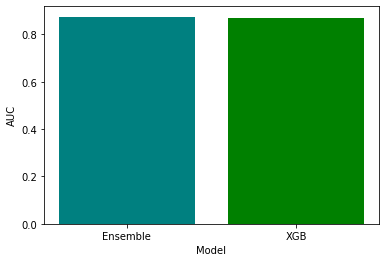

Ensemble AUC :  0.8743
XGB AUC :  0.8682


In [30]:
# could we make a quick ensemble of the XGB and NN and see if it outperforms the individual models?

# simply take average of the two probability vectors 
y_prob_ens = (y_prob[:, 1].reshape(184, 1) + y_prob_nn) / 2

# as before, set recall to 98%
threshold = 0.35
certainty = y_prob_ens > threshold
y_pred_ens = certainty.astype(int)  

# calculate metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred_ens)
roc_auc_ens = auc(fpr, tpr)
prec_ens = precision_score(y_test, y_pred_ens)
rec_ens = recall_score(y_test, y_pred_ens)
acc_ens = accuracy_score(y_test, y_pred_ens)

print("accuracy: ", acc_ens)
print("Recall: ", rec_ens)
print("Precision: ", prec_ens)
print("AUC: ", roc_auc_ens)

plot_metric((acc_ens, acc), "Accuracy", ["Ensemble", "XGB"], colours=["teal", "green"])
plot_metric((rec_ens, rec), "Recall", ["Ensemble", "XGB"], colours=["teal", "green"])
plot_metric((prec_ens, prec), "Precision", ["Ensemble", "XGB"], colours=["teal", "green"])
plot_metric((roc_auc_ens, roc_auc), "AUC", ["Ensemble", "XGB"], colours=["teal", "green"])

As can be seen, the basic ensemble of the XGB and NN model outperforms the individual XGB model in all categories. This is a significant improvement and begs the question of what other models could be added to an ensemble to achieve even better results? A potential candidate could be catBoost, which is a decision tree method specifically made for categorical data - which makes up 5/11 attributes in this dataset.

Additionally, a more advanced ensemble method could be chosen, e.g. putting more emphasis on the better models. Or even a stacking ensemble where an entirely new model is made that learns how to most efefctively weight the probabilities generated by the sub-models.

In [10]:
# catBoost algorithm (takes a long time)

hp_opt_cat = True

from catboost import CatBoostClassifier

if hp_opt_cat:
    search_space = {"iterations": Integer(4, 11),
            "depth": Integer(2, 8),
            "learning_rate": Real(0.05, 0.3), 
            "l2_leaf_reg": Real(0, 2),
            "random_strength": Real(0, 2),
            "bagging_temperature": Real(0, 2),
        }

    CB_bayes_search = BayesSearchCV(
        estimator = CatBoostClassifier(),
        search_spaces = search_space,
        scoring = 'accuracy',
        cv = StratifiedKFold(n_splits=5),
        n_jobs = 3,
        n_iter = 32
        )

    def callback(res):
        global i
        print("Run ",i)
        i += 1

    i = 0
    CB_bayes_search.fit(X_train, y_train, callback=callback)

    best_params_CB = CB_bayes_search.best_params_
    best_estimator_CB = CB_bayes_search.best_estimator_
    best_score_CB = CB_bayes_search.best_score_

Run  0
Run  1
Run  2
Run  3
Run  4
Run  5
Run  6
Run  7
Run  8
Run  9
Run  10
Run  11
Run  12
Run  13
Run  14
Run  15
Run  16
Run  17
Run  18
Run  19
Run  20
Run  21
Run  22
Run  23
Run  24
Run  25
Run  26
Run  27
Run  28
Run  29
Run  30
Run  31
0:	learn: 0.5978679	total: 164ms	remaining: 1.64s
1:	learn: 0.5321114	total: 166ms	remaining: 748ms
2:	learn: 0.4883289	total: 167ms	remaining: 446ms
3:	learn: 0.4525781	total: 169ms	remaining: 295ms
4:	learn: 0.4261666	total: 170ms	remaining: 204ms
5:	learn: 0.4045392	total: 171ms	remaining: 143ms
6:	learn: 0.3918430	total: 173ms	remaining: 98.7ms
7:	learn: 0.3804480	total: 174ms	remaining: 65.3ms
8:	learn: 0.3664789	total: 176ms	remaining: 39ms
9:	learn: 0.3549752	total: 177ms	remaining: 17.7ms
10:	learn: 0.3448948	total: 178ms	remaining: 0us


OrderedDict([('bagging_temperature', 0.0), ('depth', 4), ('iterations', 11), ('l2_leaf_reg', 2.0), ('learning_rate', 0.21742885036674708), ('random_strength', 0.42155943298433224)])
AUC:  0.8743424198947873
Precision:  0.8403361344537815
Recall:  0.9803921568627451
Accuracy:  0.8858695652173914


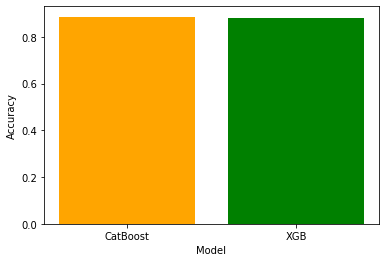

CatBoost Accuracy :  0.8859
XGB Accuracy :  0.8804


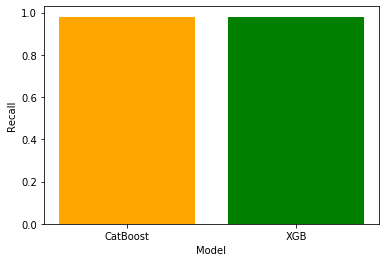

CatBoost Recall :  0.9804
XGB Recall :  0.9804


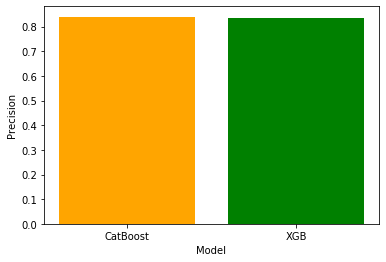

CatBoost Precision :  0.8403
XGB Precision :  0.8333


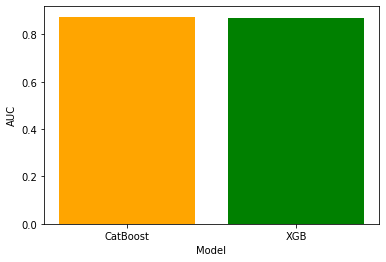

CatBoost AUC :  0.8743
XGB AUC :  0.8682


In [38]:
clf = best_estimator_CB
best_params = CB_bayes_search.best_params_
print(best_params)

# run the fitted model on the test set and obtain the probabilities that each data point lies in each class
y_prob_CB = clf.predict_proba(X_test)

# set the probabilty threshold to determine precision/recall tradeoff
threshold = 0.4

# obtain 1/0 list based on if probabiltiy is above/below threshold
certainty = y_prob_CB[:, 1] > threshold
y_pred_CB = certainty.astype(int)  

# calculate metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred_CB)
roc_auc_CB = auc(fpr, tpr)
prec_CB = precision_score(y_test, y_pred_CB)
rec_CB = recall_score(y_test, y_pred_CB)
acc_CB = accuracy_score(y_test, y_pred_CB)


print("AUC: ", roc_auc_CB)
print("Precision: " , prec_CB)
print("Recall: " , rec_CB)
print("Accuracy: ", acc_CB)

plot_metric((acc_CB, acc), "Accuracy", ["CatBoost", "XGB"], colours=["orange", "green"])
plot_metric((rec_CB, rec), "Recall", ["CatBoost", "XGB"], colours=["orange", "green"])
plot_metric((prec_CB, prec), "Precision", ["CatBoost", "XGB"], colours=["orange", "green"])
plot_metric((roc_auc_CB, roc_auc), "AUC", ["CatBoost", "XGB"], colours=["orange", "green"])

CatBoost slightly outperforms XGB in all metrics - let's add it as a third sub-model to the ensemble.

accuracy:  0.8913043478260869
Recall:  0.9803921568627451
Precision:  0.847457627118644
AUC:  0.8804399808703971


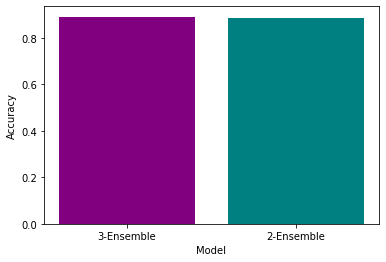

3-Ensemble Accuracy :  0.8913
2-Ensemble Accuracy :  0.8859


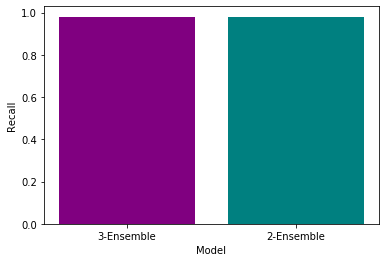

3-Ensemble Recall :  0.9804
2-Ensemble Recall :  0.9804


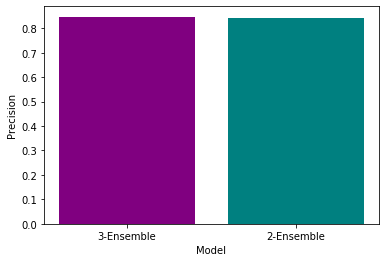

3-Ensemble Precision :  0.8475
2-Ensemble Precision :  0.8403


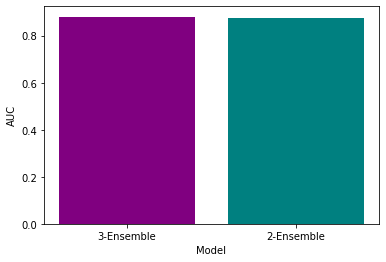

3-Ensemble AUC :  0.8804
2-Ensemble AUC :  0.8743


In [37]:
# do 3-ensemble

y_prob_3ens = (y_prob[:, 1].reshape(184, 1) + y_prob_nn + y_prob_CB[:, 1].reshape(184, 1)) / 3

# as before, set recall to 98%
threshold = 0.42
certainty = y_prob_3ens > threshold
y_pred_3ens = certainty.astype(int)  

# calculate metrics
fpr, tpr, threshold = roc_curve(y_test, y_pred_3ens)
roc_auc_3ens = auc(fpr, tpr)
prec_3ens = precision_score(y_test, y_pred_3ens)
rec_3ens = recall_score(y_test, y_pred_3ens)
acc_3ens = accuracy_score(y_test, y_pred_3ens)

print("accuracy: ", acc_3ens)
print("Recall: ", rec_3ens)
print("Precision: ", prec_3ens)
print("AUC: ", roc_auc_3ens)

plot_metric((acc_3ens, acc_ens), "Accuracy", ["3-Ensemble", "2-Ensemble"], colours=["purple", "teal"])
plot_metric((rec_3ens, rec_ens), "Recall", ["3-Ensemble", "2-Ensemble"], colours=["purple", "teal"])
plot_metric((prec_3ens, prec_ens), "Precision", ["3-Ensemble", "2-Ensemble"], colours=["purple", "teal"])
plot_metric((roc_auc_3ens, roc_auc_ens), "AUC", ["3-Ensemble", "2-Ensemble"], colours=["purple", "teal"])

As expected, the 3-ensemble model outperforms the 2-ensemble model. It was found that running this notebook several times produced varying results for the optimizers for the sub-models. More data exploration and subsequent transformation should be done to provide a hopefully less unstable training process. Also, the best models should be saved to a file so that the hyperparameter optimization steps don't have to be re-run each time.